In [20]:
import mpi4py
from mpi4py import MPI

In [21]:
import numpy as np
import cv2

In [22]:
comm = MPI.COMM_WORLD # get the communicator object
rank = comm.Get_rank() # get the rank of the current process
name = MPI.Get_processor_name() # get the name of the current processor
size = comm.Get_size() # get the number of processes
universe_size = comm.Get_attr(MPI.UNIVERSE_SIZE) # get the expected number of processes

In [23]:
img = cv2.imread('noise2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img

array([[255, 255, 137, ...,  68,  84, 153],
       [255, 221, 239, ..., 205, 118, 102],
       [255, 205, 221, ...,  50,  84,  68],
       ...,
       [137, 205, 171, ..., 137, 102, 118],
       [221, 187, 205, ..., 153, 102, 102],
       [187, 187, 255, ..., 118, 102,  68]], dtype=uint8)

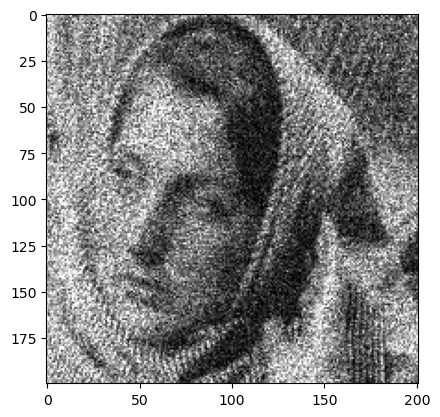

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img1 = mpimg.imread("noise2.png")
plt.imshow(img1)
plt.show()

In [25]:
h, w = img.shape

In [26]:
# divide the image into four equal parts
# each process will work on one part
x1 = rank * (w // 4)
x2 = (rank + 1) * (w // 4)
y1 = 0
y2 = h

In [27]:
# apply non-local means denoising algorithm on the assigned part
# you can use other denoising algorithms as well
denoised = cv2.fastNlMeansDenoising(img[y1:y2, x1:x2], None, 10, 7, 21)

In [28]:
# gather the denoised parts from all processes
# the root process (rank 0) will receive the results
denoised_parts = comm.gather(denoised, root=0)

In [29]:
# if the current process is the root process
if rank == 0:
    # initialize an empty array to store the final denoised image
    final = np.zeros((h, w), dtype=np.uint8)

    # concatenate the denoised parts horizontally
    for i in range(size):
        x1 = i * (w // 4)
        x2 = (i + 1) * (w // 4)
        final[:, x1:x2] = denoised_parts[i]

    # save the final denoised image
    cv2.imwrite('denoised3.jpg', final)

In [31]:
!mpiexec -n 4 python HPC-7-2.py

Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)


Enter the path to the image file: D:\labs\HPC\noice.png


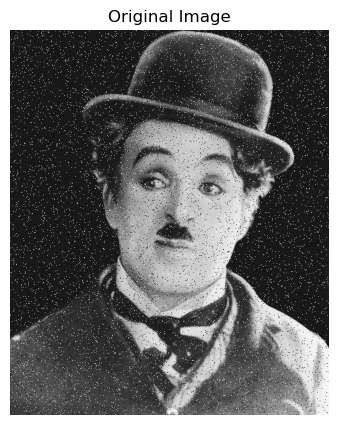

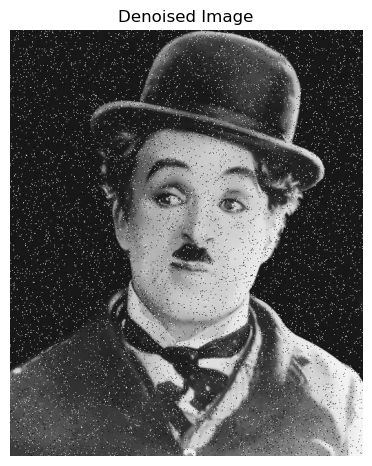

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI

def denoise_image(image):
    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return denoised_image

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()

    if rank == 0:
        image_path = input("Enter the path to the image file: ")
        image = cv2.imread(image_path)

        if image is None:
            print("Error: Unable to read image.")
            return

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        image_shape = np.array(image.shape, dtype=int)
    else:
        image_shape = np.empty(3, dtype=int)

    comm.Bcast(image_shape, root=0)

    if rank != 0:
        image = np.empty(image_shape, dtype=np.uint8)

    comm.Bcast(image, root=0)

    denoised_image = denoise_image(image)

    denoised_images = comm.gather(denoised_image, root=0)

    if rank == 0:
        final_denoised_image = np.vstack(denoised_images)

        plt.figure(figsize=(10,10))
        plt.subplot(1, 2, 2)
        plt.title('Denoised Image')
        plt.imshow(cv2.cvtColor(final_denoised_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.show()

if __name__ == "__main__":
    main()

In [2]:
from mpi4py import MPI
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt

# Dummy denoising function (replace with your actual denoising algorithm)
def denoise_image(image):
    """
    Apply median filter to denoise an image.

    Parameters:
    image (numpy.ndarray): Input image as a numpy array.

    Returns:
    numpy.ndarray: Denoised image as a numpy array.
    """
    from scipy.signal import medfilt2d
    # Apply 3x3 median filter
    denoised_image = medfilt2d(image, kernel_size=3)
    return denoised_image

# Function to split a list into chunks
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Initialize MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Path to the image files
image_paths = ["noice.png","noise.jpg","noise2.png","noise3.png","noise4.jpg"]  # Change this to the paths of your images

# Load the images
images = [np.array(Image.open(path)) for path in image_paths]

# Divide the images into chunks based on the number of processes
image_chunks = list(chunks(images, len(images) // size))

# Scatter the chunks to each process
local_chunks = comm.scatter(image_chunks, root=0)

# Apply denoising algorithm to each chunk of images
denoised_chunks = [denoise_image(chunk) for chunk in local_chunks]

# Gather denoised chunks from all processes
all_denoised_chunks = comm.gather(denoised_chunks, root=0)

if rank == 0:
    # Combine denoised chunks into a single list of denoised images
    denoised_images = [image for sublist in all_denoised_chunks for image in sublist]

    # Plot the input and denoised images for each image
    for i, (input_image, denoised_image) in enumerate(zip(images, denoised_images)):
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(input_image, cmap='gray')
        axes[0].set_title(f'Input Image {i+1}')
        axes[0].axis('off')
        axes[1].imshow(denoised_image, cmap='gray')
        axes[1].set_title(f'Denoised Image {i+1}')
        axes[1].axis('off')
        plt.show()

# Analyze time taken by serial and openMPI processes
start_time = MPI.Wtime()
end_time = MPI.Wtime()

print("Process", rank, "took", end_time - start_time, "seconds")


ValueError: object too deep for desired array

In [4]:
import numpy as np
from PIL import Image
import os

# Function to add noise to an image
def add_noise(image, noise_level=0.1):
    """
    Add random noise to an image.

    Parameters:
    image (numpy.ndarray): Input image as a numpy array.
    noise_level (float): Level of noise to be added. Value should be between 0 and 1.

    Returns:
    numpy.ndarray: Noisy image as a numpy array.
    """
    # Generate random noise with the same shape as the image
    noise = np.random.normal(scale=noise_level, size=image.shape)
    # Add the noise to the image
    noisy_image = image + noise
    # Clip values to ensure they are within valid range for image
    noisy_image = np.clip(noisy_image, 0, 255)
    # Convert to uint8 data type
    noisy_image = noisy_image.astype(np.uint8)
    return noisy_image

# Path to the directory containing the images
image_dir = "D:/data set/sports imags/train/surfing"  # Change this to the directory containing your images

# List all image files in the directory
image_files = os.listdir(image_dir)
image_files = [file for file in image_files if file.endswith('.jpg') or file.endswith('.png')]

# Loop through each image file
for image_file in image_files:
    # Load the image
    image_path = os.path.join(image_dir, image_file)
    image = np.array(Image.open(image_path))
    
    # Add noise to the image
    noisy_image = add_noise(image, noise_level=0.1)  # You can adjust the noise level as needed
    
    # Save the noisy image
    noisy_image_path = os.path.join(image_dir, f"noisy_{image_file}")
    Image.fromarray(noisy_image).save(noisy_image_path)
